# NEOPRENE notebooks

***

This notebook is part of a notebook collection available at the [NEOPRENE Project Site](https://github.com/IHCantabria/NEOPRENE) for illustration, reproducibility and reusability purposes. This notebook is licensed under the [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0).

![Creative Commons License >](https://i.creativecommons.org/l/by/4.0/88x31.png)

## Calibrating and synthetic simulations of Rainfall with the NSRPM.

In this script we calibrate the NSRPM (Neyman Scott Rectangular Pulse Model) using two rainfall series with different rainfall regimes: one with daily data located in the north of Spain (Bilbao), on a temperate climate (Cfb), and other with hourly data located in Sevilleta (New Mexico, USA), on a semi-arid climate (BSh-BSk). The calibration parameters are used to simulate several decades of synthetic rainfall data which can be very useful for rainfall extreme analysis or disaggregation purposes, among other applications.

The script also contains:

1. a validation section where the observed series are compared with the simulated ones in terms of their statistics and exceedance probabilities. 

2. a disaggregation function to disaggreate daily to hourly rainfall data.

Please, be advised that some of the processes may take up to 5 minutes in a modern computer.

### Load packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from NEOPRENE.NSRP.HiperParams import Calibration as Calhps, Simulation as Simhps
from NEOPRENE.NSRP.Calibration import Calibration
from NEOPRENE.NSRP.Statistics import Statistics
from NEOPRENE.NSRP.Simulation import Simulation
from NEOPRENE.NSRP.utils import compare_statistics, exceedence_probability, disaggregate_rainfall

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Example 1. Calibration and validation of daily data

### Loading daily rainfall data for Bilbao

In [4]:
Serie_Bilbao = pd.read_csv('auxiliary-materials/Bilbao_Daily.csv', sep=";", decimal=".", index_col=0, parse_dates=True)
Serie_Bilbao[Serie_Bilbao.values<0] = np.nan
Input_Serie = pd.DataFrame(index=Serie_Bilbao.index)
Input_Serie['Rain'] = Serie_Bilbao.values

### Plotting daily data and seasonality

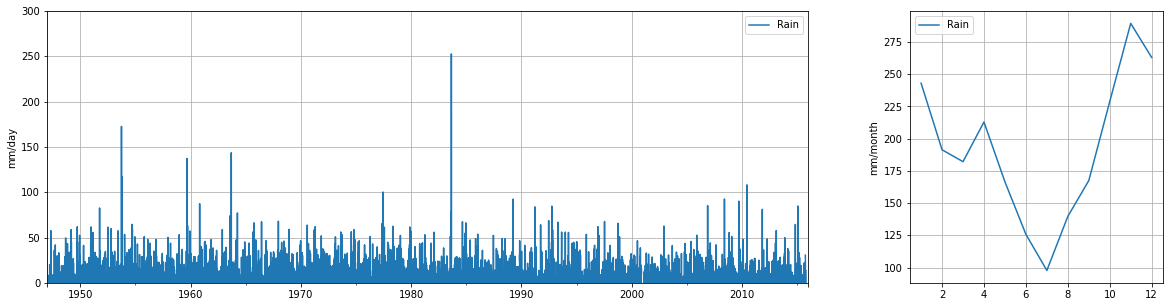

In [5]:
f, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(20, 5))

t1=str(Input_Serie.index.year[0])
t2=str(Input_Serie.index.year[-1])
Input_Serie.plot(xlim=(t1, t2),  ylim=(0, 300), ax = ax0)
ax0.grid(True)
ax0.set_ylabel('mm/day')

grouped_m = Input_Serie.groupby(lambda x: x.month)
Month_sum = grouped_m.sum()*24/(len(Input_Serie>=0)/30)
Month_sum.plot(ax = ax1)
ax1.grid(True)
ax1.set_ylabel('mm/month');

### Calibration

The calibration input file ([Input_Cal_Bilbao.yml](https://github.com/IHCantabria/NEOPRENE/blob/main/notebooks/Input_Cal_Bilbao.yml)) contains the hyperparameters to calibrate the model. This hyperparameters are loaded by the ```Calibration``` class within the ```NEOPRENE.NSRP.HiperParams``` module. In this notebook, the module is loaded as ```Calhps```.

Input rainfall statistics can be directly calculated by the software from a time series or can be introduced from a file with the statistics (both options are shown in the present notebook).

A description of the hyperparamters available in the calibration file ([Input_Cal_Bilbao.yml](https://github.com/IHCantabria/NEOPRENE/blob/main/notebooks/Input_Cal_Bilbao.yml)) can be found within the ```doc``` folder of the [project repository](https://github.com/IHCantabria/NEOPRENE).

In [6]:
# Reading hiperparamteres for the calibration
hiper_params_cal = Calhps('./Input_Cal_Bilbao.yml')

The original time series statistics are computed first, as the model calibrates against those statistics. Once the statistics have been computed, the library does not need the complete time series anymore.

In [7]:
# Input statistics calculated from a Rainfall serie
statistics_model_1 = Statistics(hiper_params_cal, time_series = Input_Serie)

# Input statistics from file 
statistics_model_2 = Statistics(hiper_params_cal, file = 'auxiliary-materials/statististics_Bilbao.csv')

The hyperparameters are passed to the Calibration class which return a calibrator object. This object can be used as a function, that receives the statistics that need to be reproduced by the model. The object can also save the calibrated parameters to disk for later use.

In [8]:
CAL              = Calibration(hiper_params_cal) 
CAL1             = CAL(statistics_model_1, verbose=False)
#CAL2             = CAL(statistics_model_2, verbose=False)

os.makedirs('./BILBAO/CAL1/',exist_ok=True)

CAL1.save_files('./BILBAO/CAL1/')
#CAL2.save_files('./CAL2/')



################################################################################
Adjustment of parameters using the Particle Swarm Optimization (PSO)




### Simulation

The input simulation file ([Input_Sim_Bilbao.yml](https://github.com/IHCantabria/NEOPRENE/blob/main/notebooks/Input_Sim_Bilbao.yml)) contains the hypermarametes for rainfall simulation.

A description of the hyperparamters available in the simulation file ([Input_Sim_Bilbao.yml](https://github.com/IHCantabria/NEOPRENE/blob/main/notebooks/Input_Sim_Bilbao.yml)) can be found within the ```doc``` folder of the [project repository](https://github.com/IHCantabria/NEOPRENE).

The first thing we do is to load the hyperparameters

In [9]:
# Reading hiperparamteres for the simulation
hiper_params_sim = Simhps('./Input_Sim_Bilbao.yml')

And those hyperparameters are then used to configure the Simulation class, which return a Simulation object that is used in a very similar way to the Calibration object.

In [10]:
SIM              = Simulation(hiper_params_sim) 

# Input parameters from the model
SIM1             = SIM(params_cal = CAL1)

# Input parameters from a dataframe
#SIM2             = SIM(params_cal = './CAL2/Calibrated_parameters.csv')
os.makedirs('./BILBAO/SIM1/',exist_ok=True)
SIM1.save_files('./BILBAO/SIM1/')
#SIM2.save_files('./SIM2/')



################################################################################
Synthetic simulation


Total cumulative rainfall - Analytical estimation =        72663.82
Total cumulative rainfall -             Simulated =        72332.97


### Verification

The curve of exceedence probabilities is shown to evaluate the quality of the fit of the simulations and the observations

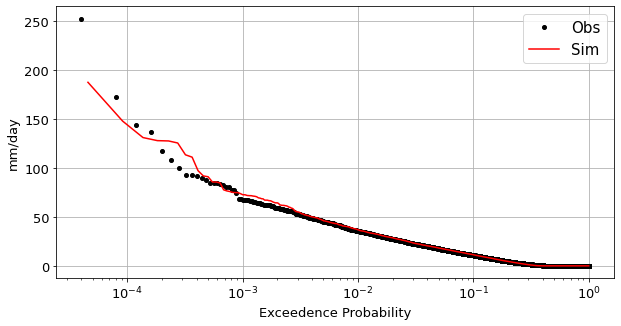

In [13]:
# Comparing exceedence Probability betwen Observed and Simulated series
exceedence_probability(Input_Serie, SIM1.Daily_Simulation, SIM1.temporal_resolution)

### Validation

Another set of verification plots is generated where the value of different observed statistics (dashed line) is compared against the fitted statistics (blue squares), that is, the best values of the statistic that the optimal parameters were able to reproduce, and against the simulated statistics (red triangles), the values of the statistics that were obtained when simulating synthetic time series with the calibrated parameters.

The model correctly reproduces those parameters for which it is calibrated. Those parameters that do not participate in the calibration procedure may exhibit a more erratic behavior, thus the differences between the calibrated and simulated values of the statistics.

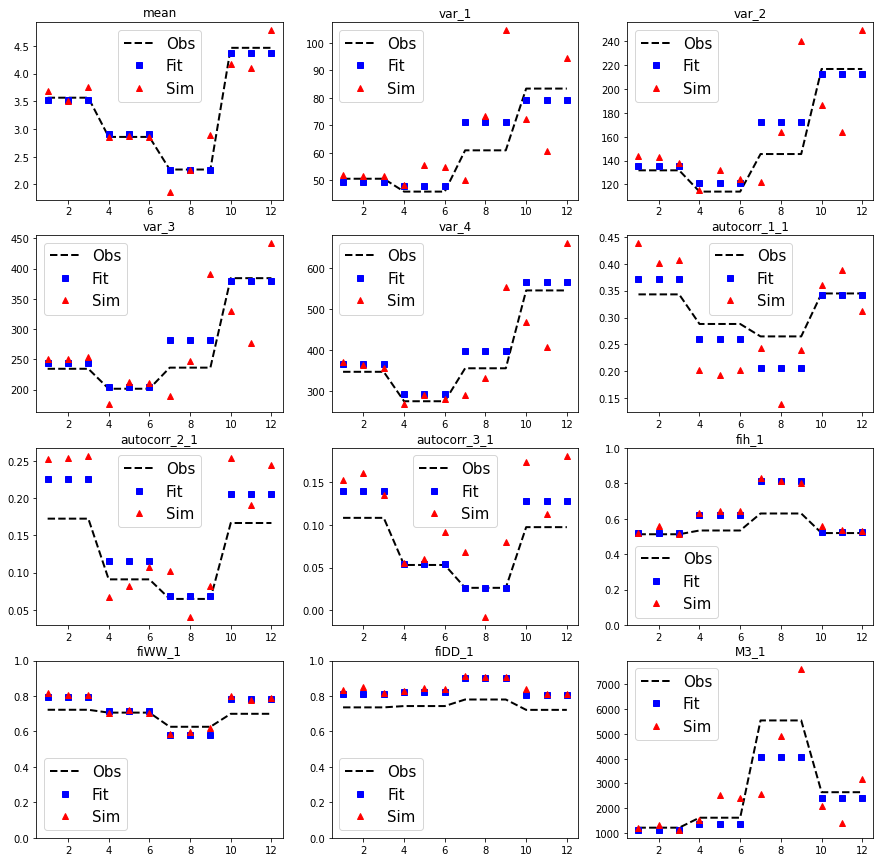

In [11]:
# Comparing the values of the statistcs (observed, fitted and simulated).
compare_statistics(CAL1, SIM1)

## Example 2. Disaggregation of daily data to hourly data

Disaggregation process might take some minutes to dissagregate several decades of data. Here we select only 5 year as an example

In [14]:
# Period selected from the input (onserved) serie
year1 = 2000; year2 = 2005
x_series = Input_Serie[(Input_Serie.index.year >= year1) & (Input_Serie.index.year < year2)]

In [15]:
# Defining hourly synthetic serie
y_series = SIM1.Hourly_Simulation.copy()

In [16]:
# Daily-to-hourly disaggregation
hourly_disaggregation = disaggregate_rainfall(x_series, y_series)

In [17]:
# Resampling hourly disaggregated serie to daily one
daily_disaggregation = hourly_disaggregation.resample('D').agg(pd.Series.sum, min_count=1)
# Calculating statistics from the disaggregated daily resample serie and for the period selected from the Input serie
statistics_model_3 = Statistics(hiper_params_cal, time_series = x_series)
statistics_disaggregated = Statistics(hiper_params_cal, time_series = daily_disaggregation)

In [18]:
# Comparing daily observed statiscis with dialy dissagregated ones

statistics_model_3.statististics_dataframe.compare(statistics_disaggregated.statististics_dataframe)

(1, 2, 3)               (4, 5, 6)               (7, 8, 9)  \
                    self       other        self       other        self   
mean            2.714014    2.533721    2.167473    2.165735    1.709783   
var_1          30.358070   28.940479   24.275074   24.187474   24.078709   
var_2          86.207178   75.636366   67.954721   67.622180   54.092921   
var_3         144.872544  140.084550  101.244793  100.271994   88.334097   
var_4         215.418474  217.206968  178.446506  176.638133  127.944200   
autocorr_1_1    0.375057    0.383584    0.323616    0.318693    0.171706   
autocorr_2_1    0.178015    0.192030    0.085590    0.083599    0.021917   
autocorr_3_1    0.092411    0.108973   -0.015097   -0.014113    0.006131   
fih_1           0.546318    0.572062    0.553846    0.556044    0.613043   
fiWW_1          0.685864    0.673575    0.704433    0.698020    0.696629   
fiDD_1          0.739130    0.755814    0.761905    0.758893    0.808511   
M3_1          463.771772  451.533545  394.297866  392.345732  618.928857   

                         (10, 11, 12)               
                   other         self        other  
mean            1.707742     4.527751     4.130288  
var_1          24.191582    70.135785    67.248476  
var_2          54.519815   185.087648   181.674608  
var_3          88.595102   329.570474   329.764699  
var_4         128.475348   409.274250   419.737091  
autocorr_1_1    0.171288     0.384615     0.411801  
autocorr_2_1    0.019538     0.147500     0.177140  
autocorr_3_1    0.005126     0.083210     0.105766  
fih_1           0.626087     0.483254     0.528261  
fiWW_1          0.656977     0.703704     0.718894  
fiDD_1          0.795139     0.683168     0.748971  
M3_1          630.089177  1642.952947  1702.353132

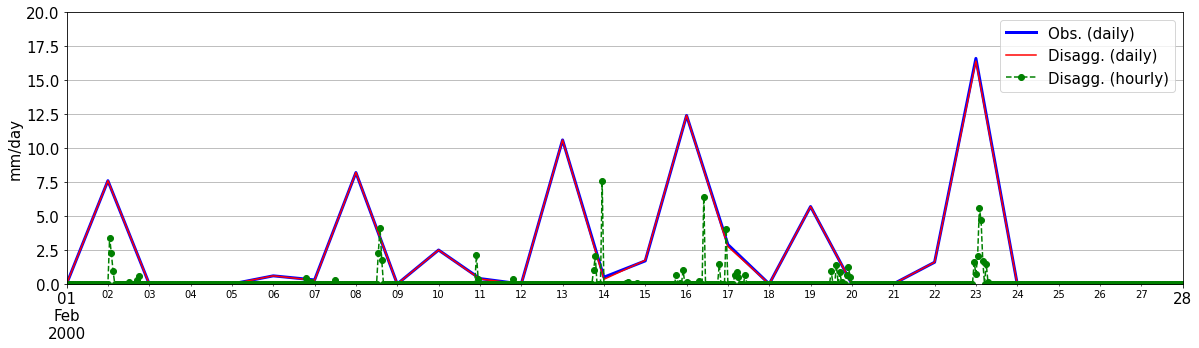

In [19]:
# Plotting observed daily series and disaggregated ones (daily and horly) for a specific period
t1 = str(year1) + '/02/01'; t2 = str(year1) + '/02/28'
f = x_series.plot(xlim=(t1, t2),  ylim=(0, 20), color = 'b', style= '-', linewidth = '3', figsize = (20, 5))
l = daily_disaggregation.plot(xlim=(t1, t2),  ylim=(0, 20), color = 'r', style = '--', ax = f)
hourly_disaggregation.plot(xlim=(t1, t2),  ylim=(0, 20), color = 'g', style = '--o', ax = f)
plt.legend(['Obs. (daily)', 'Disagg. (daily)', 'Disagg. (hourly)'], fontsize = 15)
plt.grid(True)
plt.tick_params(axis = 'both', labelsize = 15)
plt.ylabel('mm/day', fontsize = 15);

## Example 3. Calibration and Simulation of hourly data

### Loading hourly rainfall data for Sevilleta

In [20]:
Serie_Sevilleta=pd.read_csv('auxiliary-materials/Sevilleta_Hourly.csv', sep=",", decimal=".", index_col=0, parse_dates = True)
Serie_Sevilleta[Serie_Sevilleta.values<0]=np.nan
Input_Serie=pd.DataFrame(index=Serie_Sevilleta.index)
Input_Serie['Rain']=Serie_Sevilleta.values

### Plotting hourly data and seasonality

Text(0, 0.5, 'mm/month')

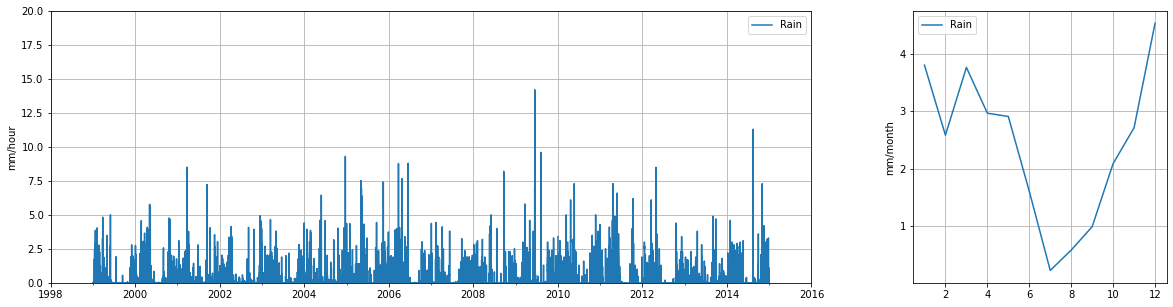

In [21]:
f, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(20, 5))

t1=str(Input_Serie.index.year[0]); t2=str(Input_Serie.index.year[-1])
Input_Serie.plot(xlim=(t1, t2),  ylim=(0, 20), ax = ax0)
ax0.grid(True)
ax0.set_ylabel('mm/hour')

grouped_m = Input_Serie.groupby(lambda x: x.month)
Month_sum=grouped_m.sum()*24/(len(Input_Serie>=0)/30)
Month_sum.plot(ax = ax1)
ax1.grid(True)
ax1.set_ylabel('mm/month')

### Calibration

In [22]:
hiper_params_cal = Calhps('./Input_Cal_Sevilleta.yml')
statistics_model_1 = Statistics(hiper_params_cal, time_series = Input_Serie)

In [23]:
CAL              = Calibration(hiper_params_cal) 
CAL1             = CAL(statistics_model_1, verbose=False)

os.makedirs('./SEVILLETA/CAL1/', exist_ok=True)

CAL1.save_files('./SEVILLETA/CAL1/')



################################################################################
Adjustment of parameters using the Particle Swarm Optimization (PSO)




### Simulation

In [24]:
hiper_params_sim = Simhps('./Input_Sim_Sevilleta.yml')

SIM              = Simulation(hiper_params_sim) 
SIM1             = SIM(params_cal = CAL1)
#SIM2             = SIM(params_cal = './CAL2/Calibrated_parameters.csv')



################################################################################
Synthetic simulation


Total cumulative rainfall - Analytical estimation - Storm 1 =         1055.24
Total cumulative rainfall - Analytical estimation - Storm 2 =         1076.42
Total cumulative rainfall - Analytical estimation =         2131.66
Total cumulative rainfall -             Simulated =         1887.63


In [25]:
os.makedirs('./SEVILLETA/SIM1/')
SIM1.save_files('./SEVILLETA/SIM1/')

### Validation

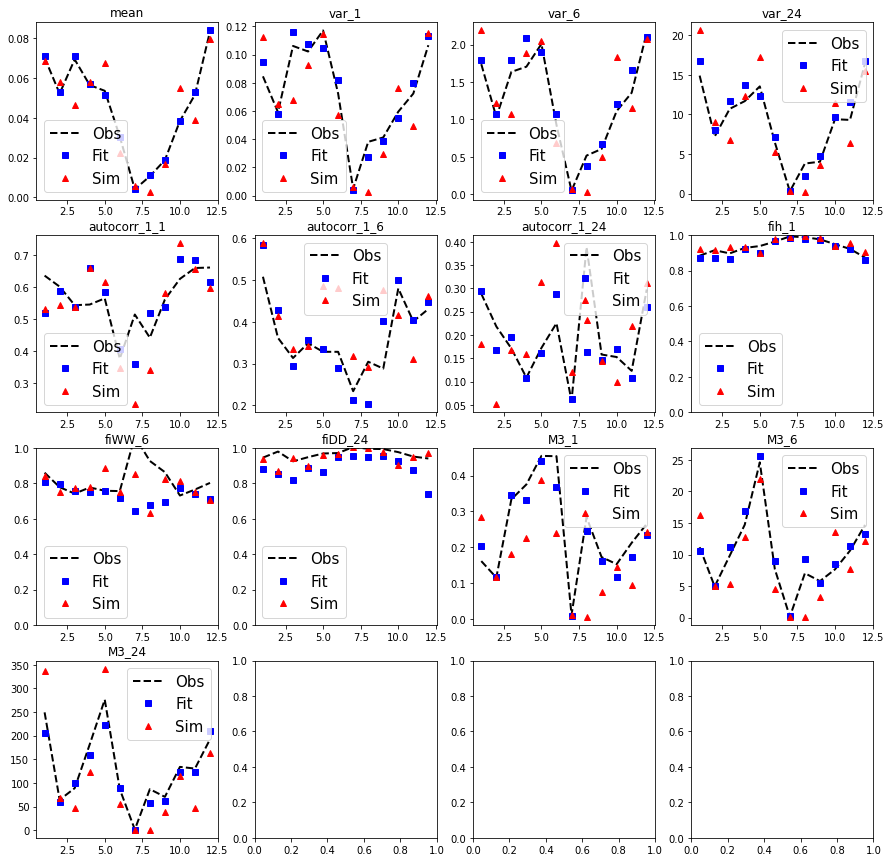

In [26]:
# Comparing the values of the statistcs (observed, fitted and simulated).
compare_statistics(CAL1, SIM1)

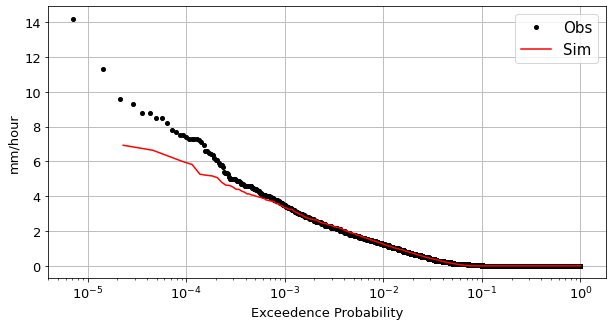

In [27]:
# Comparing exceedence Probability betwen Observed and Simulated series
exceedence_probability(Input_Serie, SIM1.Hourly_Simulation, SIM1.temporal_resolution)

## Session info

In [28]:
!conda list

# packages in environment at C:\Anaconda3\envs\NEOPRENE:
#
# Name                    Version                   Build  Channel
argon2-cffi               20.1.0           py39h2bbff1b_1  
async_generator           1.10               pyhd3eb1b0_0  
attrs                     21.2.0             pyhd3eb1b0_0  
backcall                  0.2.0              pyhd3eb1b0_0  
bleach                    4.0.0              pyhd3eb1b0_0  
ca-certificates           2021.7.5             haa95532_1  
certifi                   2021.5.30        py39haa95532_0  
cffi                      1.14.6           py39h2bbff1b_0  
colorama                  0.4.4              pyhd3eb1b0_0  
cycler                    0.10.0                   pypi_0    pypi
datetime                  4.3                      pypi_0    pypi
debugpy                   1.4.1            py39hd77b12b_0  
decorator                 5.1.0              pyhd3eb1b0_0  
defusedxml                0.7.1              pyhd3eb1b0_0  
entrypoints           